# Clasificación utilizando Modelos de Machine Learning

## Importación de Librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time 
from matplotlib.colors import ListedColormap

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

sns.set()

## Funciones y Dataframes Auxiliares

In [2]:
seed = 17

In [3]:
# DataFrame para una evaluación general al final
model_performance = pd.DataFrame(columns=['Accuracy','Recall','Precision','F1-Score','MCC score','Entrenamiento (s)','Predicción (s)','Tiempo Total (s)'])

In [4]:
# Función para mostrar las métricas

def muestra_metricas(model_name, y_test, y_predic, start_time=None, end_train_time=None, end_predict_time=None):
    """
    Función simple para personalizar las métrica a imprimir para cada modelo analizado.
    model_name: string con el nombre del modelo
    y_test: recibe el vector de salida real
    y_predic: recibe el vector de salida predicho por el modelo
    """

    accuracy = accuracy_score(y_test, y_predic)
    recall = recall_score(y_test, y_predic, average='weighted') # average permite definir cómo se computan estas métricas para múltiples clases de salida
    precision = precision_score(y_test, y_predic, average='weighted')
    f1s = f1_score(y_test, y_predic, average='weighted')
    MCC = matthews_corrcoef(y_test, y_predic)

    print("#######################################")
    print("Accuracy (Exactitud): "+ "{:.2%}".format(accuracy))
    print("Recall (Recuperación): "+ "{:.2%}".format(recall))
    print("Precision (Precisión): "+ "{:.2%}".format(precision))
    print("F1-Score: "+ "{:.2%}".format(f1s))
    print("MCC (Matthews Correlation Coefficient): "+ "{:.2%}".format(MCC))    # Matthews correlation coefficient: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html

    if (start_time != None and end_train_time != None and end_predict_time != None):
        print("Tiempo de entrenamiento: {:.4f} s".format(end_train_time-start_time))
        print("Tiempo de predicción: {:.4f} s".format(end_predict_time-end_train_time))
        print("Tiempo total: {:.4f} s".format(end_predict_time-start_time))

    print("#######################################")
    model_performance.loc[model_name] = [accuracy, recall, precision, f1s, MCC, end_train_time-start_time, end_predict_time-end_train_time, end_predict_time-start_time]

In [5]:
def plot_confusion_matrix(y_true, y_preds, labels=None, model_name=None):
    """
    Función para graficar la Matrix de confusión
    y_true: vector de salida real
    y_predic: vector de salida predicho por el modelo
    labels: opcional, para nombrar las clases. Lista con strings
    model_name: opcional, para poner un título al gráfico
    """
    cm = confusion_matrix(y_true, y_preds)
    cmd = ConfusionMatrixDisplay(cm, display_labels=labels)
    cmd.plot()
    cmd.ax_.set(xlabel='Clase Predicha', ylabel='Clase Real')
    if model_name:
        cmd.ax_.set(title=model_name)

    # Midamos la sensibilidad y especificidad
    if model_name:
        print("Clasificador: {}".format(model_name))
    P = np.sum(cm[1, :])
    N = np.sum(cm[0, :])
    TP = cm[1, 1]
    TN = cm[0, 0]
    TPR = TP/P
    TNR = TN/N
    print("Sensibilidad: {:.4f}".format(TP/P))
    print("Especificidad: {:.4f}".format(TN/N))
    print("Exactitud balanceada: {:.4f}".format((TPR + TNR)/2))

## Carga del *Dataset*

In [6]:
# Cargar dataset
df = pd.read_csv("../datasets/chicago_crimes_and_stations_2024_final_PCA.csv")
test_df = pd.read_csv("../datasets/chicago_crimes_and_stations_2024_final_PCA_test.csv")


X = df.drop(["Arrest_tag"], axis=1)
y = df["Arrest_tag"]

X_test = test_df.drop(["Arrest_tag"], axis=1)
y_test = test_df["Arrest_tag"]

In [7]:
# como siempre vamos separando nuestras variables predictoras de la variable a predecir
X_train = X
y_train = y

## Entrenamiento y Prueba de Modelos

### Modelo de Regresión Logística


In [9]:
start = time.time() # Estampa de tiempo para computar métricas

# Entrenamiento
model_logistic = LogisticRegression(random_state = seed)
model_logistic.fit(X_train, y_train)
end_train = time.time()

# Predicciones
pred_logistic = model_logistic.predict(X_test)
end_predict = time.time()

print("Classification Report: \n", classification_report(y_test, pred_logistic))
muestra_metricas("Regresión Logística", y_test, pred_logistic, start, end_train, end_predict)

Classification Report: 
               precision    recall  f1-score   support

           0       0.87      0.84      0.86     43780
           1       0.18      0.22      0.20      6964

    accuracy                           0.76     50744
   macro avg       0.53      0.53      0.53     50744
weighted avg       0.78      0.76      0.77     50744

#######################################
Accuracy (Exactitud): 75.68%
Recall (Recuperación): 75.68%
Precision (Precisión): 77.69%
F1-Score: 76.64%
MCC (Matthews Correlation Coefficient): 5.74%
Tiempo de entrenamiento: 0.1823 s
Tiempo de predicción: 0.0035 s
Tiempo total: 0.1859 s
#######################################


Clasificador: Regresión Logística
Sensibilidad: 0.2200
Especificidad: 0.8422
Exactitud balanceada: 0.5311


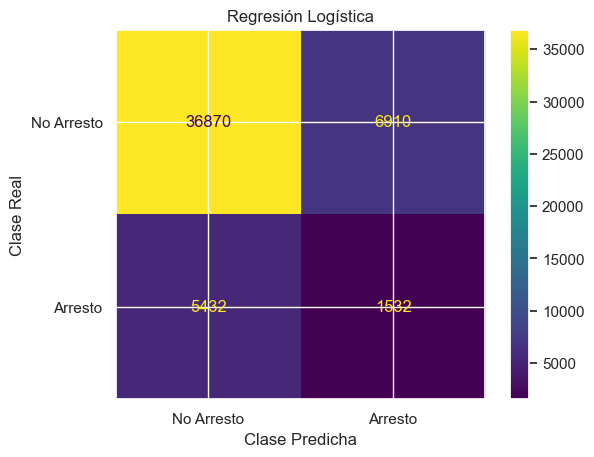

In [10]:
# Gráfica Matriz de Confusión
plot_confusion_matrix(y_test, pred_logistic, labels=["No Arresto", "Arresto"], model_name="Regresión Logística")

### Clasificador KNN

In [11]:
start = time.time() # Estampa de tiempo para computar métricas

# Entrenamiento
model_knn = KNeighborsClassifier(n_neighbors=10, metric="minkowski")
model_knn.fit(X_train, y_train)
end_train = time.time()

# Predicciones
pred_knn = model_knn.predict(X_test)
end_predict = time.time()

print("Classification Report: \n", classification_report(y_test, pred_knn))
muestra_metricas("K-Nearest Neighboors (k=10)", y_test, pred_knn, start, end_train, end_predict)

Classification Report: 
               precision    recall  f1-score   support

           0       0.88      0.78      0.83     43780
           1       0.19      0.33      0.24      6964

    accuracy                           0.72     50744
   macro avg       0.54      0.55      0.54     50744
weighted avg       0.79      0.72      0.75     50744

#######################################
Accuracy (Exactitud): 72.00%
Recall (Recuperación): 72.00%
Precision (Precisión): 78.52%
F1-Score: 74.78%
MCC (Matthews Correlation Coefficient): 8.84%
Tiempo de entrenamiento: 1.4018 s
Tiempo de predicción: 5.1876 s
Tiempo total: 6.5894 s
#######################################


Clasificador: KNN (k=10)
Sensibilidad: 0.3257
Especificidad: 0.7828
Exactitud balanceada: 0.5542


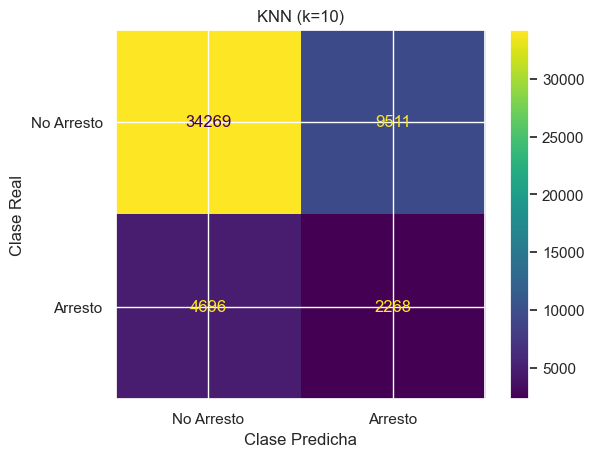

In [12]:
# Gráfica Matriz de Confusión
plot_confusion_matrix(y_test, pred_knn, labels=["No Arresto", "Arresto"], model_name="KNN (k=10)")

### *Support Vector Machines* (SVM)

In [13]:
start = time.time() # Estampa de tiempo para computar métricas

# Entrenamiento
model_svm = LinearSVC(random_state=seed)
model_svm.fit(X_train, y_train)
end_train = time.time()

# Predicciones
pred_svm = model_svm.predict(X_test)
end_predict = time.time()

print("Classification Report: \n", classification_report(y_test, pred_svm))
muestra_metricas("SVM Linear", y_test, pred_svm, start, end_train, end_predict)

Classification Report: 
               precision    recall  f1-score   support

           0       0.87      0.84      0.86     43780
           1       0.18      0.22      0.20      6964

    accuracy                           0.76     50744
   macro avg       0.53      0.53      0.53     50744
weighted avg       0.78      0.76      0.77     50744

#######################################
Accuracy (Exactitud): 75.73%
Recall (Recuperación): 75.73%
Precision (Precisión): 77.69%
F1-Score: 76.66%
MCC (Matthews Correlation Coefficient): 5.74%
Tiempo de entrenamiento: 0.3177 s
Tiempo de predicción: 0.0036 s
Tiempo total: 0.3213 s
#######################################


Clasificador: Linear SVM
Sensibilidad: 0.2191
Especificidad: 0.8429
Exactitud balanceada: 0.5310


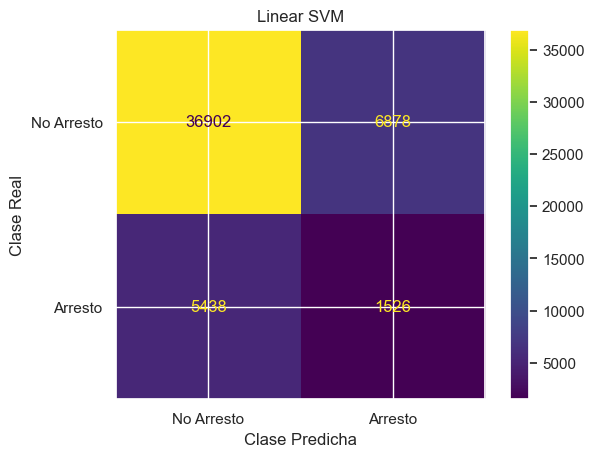

In [14]:
# Gráfica Matriz de Confusión
plot_confusion_matrix(y_test, pred_svm, labels=["No Arresto", "Arresto"], model_name="Linear SVM")

### Árbol de Decisión


In [15]:
start = time.time() # Estampa de tiempo para computar métricas

# Entrenamiento
model_tree = DecisionTreeClassifier(criterion='entropy', splitter='best', 
                                        max_depth=None, min_samples_split=2, min_samples_leaf=1, 
                                        random_state=seed)
model_tree.fit(X_train, y_train)
end_train = time.time()

# Predicciones
pred_tree = model_tree.predict(X_test)
end_predict = time.time()

print("Classification Report: \n", classification_report(y_test, pred_tree))
muestra_metricas("Árbol de Decisión", y_test, pred_tree, start, end_train, end_predict)

Classification Report: 
               precision    recall  f1-score   support

           0       0.88      0.76      0.82     43780
           1       0.19      0.34      0.24      6964

    accuracy                           0.71     50744
   macro avg       0.53      0.55      0.53     50744
weighted avg       0.78      0.71      0.74     50744

#######################################
Accuracy (Exactitud): 70.64%
Recall (Recuperación): 70.64%
Precision (Precisión): 78.39%
F1-Score: 73.87%
MCC (Matthews Correlation Coefficient): 8.18%
Tiempo de entrenamiento: 11.6030 s
Tiempo de predicción: 0.0214 s
Tiempo total: 11.6243 s
#######################################


Clasificador: Árbol de Decisión
Sensibilidad: 0.3379
Especificidad: 0.7650
Exactitud balanceada: 0.5514


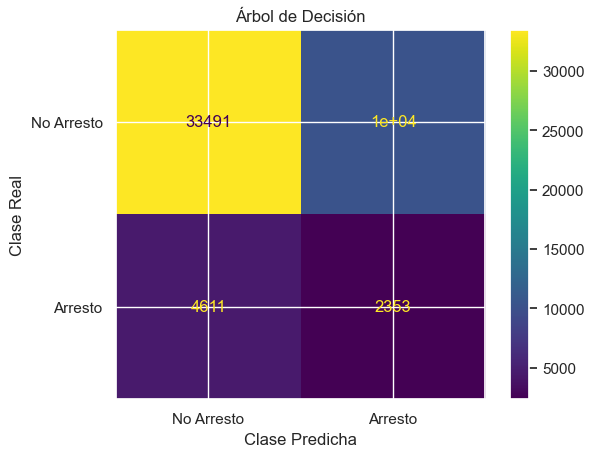

In [16]:
# Gráfica Matriz de Confusión
plot_confusion_matrix(y_test, pred_tree, labels=["No Arresto", "Arresto"], model_name="Árbol de Decisión")

### Random Forest

In [17]:
start = time.time() # Estampa de tiempo para computar métricas

# Entrenamiento
model_forest = RandomForestClassifier(n_estimators=20, criterion='entropy', random_state=seed)
model_forest.fit(X_train, y_train)
end_train = time.time()

# Predicciones
pred_forest = model_forest.predict(X_test)
end_predict = time.time()

print("Classification Report: \n", classification_report(y_test, pred_forest))
muestra_metricas("Random Forest", y_test, pred_forest, start, end_train, end_predict)

Classification Report: 
               precision    recall  f1-score   support

           0       0.88      0.89      0.88     43780
           1       0.25      0.24      0.25      6964

    accuracy                           0.80     50744
   macro avg       0.57      0.56      0.57     50744
weighted avg       0.79      0.80      0.80     50744

#######################################
Accuracy (Exactitud): 79.77%
Recall (Recuperación): 79.77%
Precision (Precisión): 79.42%
F1-Score: 79.59%
MCC (Matthews Correlation Coefficient): 13.10%
Tiempo de entrenamiento: 43.2022 s
Tiempo de predicción: 0.3831 s
Tiempo total: 43.5853 s
#######################################


Clasificador: Random Forest
Sensibilidad: 0.2428
Especificidad: 0.8859
Exactitud balanceada: 0.5644


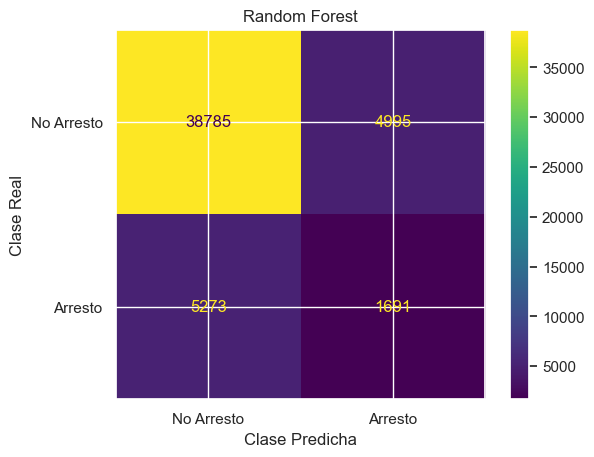

In [18]:
# Gráfica Matriz de Confusión
plot_confusion_matrix(y_test, pred_forest, labels=["No Arresto", "Arresto"], model_name="Random Forest")

### Bagging

In [25]:
start = time.time() # Estampa de tiempo para computar métricas

# Entrenamiento
model_bagging = BaggingClassifier(estimator=LogisticRegression(), n_estimators=20,random_state=seed)
model_bagging.fit(X_train, y_train)
end_train = time.time()

# Predicciones
pred_bagging = model_bagging.predict(X_test)
end_predict = time.time()

print("Classification Report: \n", classification_report(y_test, pred_bagging))
muestra_metricas("Bagging (LR)", y_test, pred_bagging, start, end_train, end_predict)

Classification Report: 
               precision    recall  f1-score   support

           0       0.87      0.84      0.86     43780
           1       0.18      0.22      0.20      6964

    accuracy                           0.76     50744
   macro avg       0.53      0.53      0.53     50744
weighted avg       0.78      0.76      0.77     50744

#######################################
Accuracy (Exactitud): 75.77%
Recall (Recuperación): 75.77%
Precision (Precisión): 77.68%
F1-Score: 76.68%
MCC (Matthews Correlation Coefficient): 5.71%
Tiempo de entrenamiento: 4.8047 s
Tiempo de predicción: 0.2640 s
Tiempo total: 5.0687 s
#######################################


Clasificador: Bagging (LR)
Sensibilidad: 0.2181
Especificidad: 0.8435
Exactitud balanceada: 0.5308


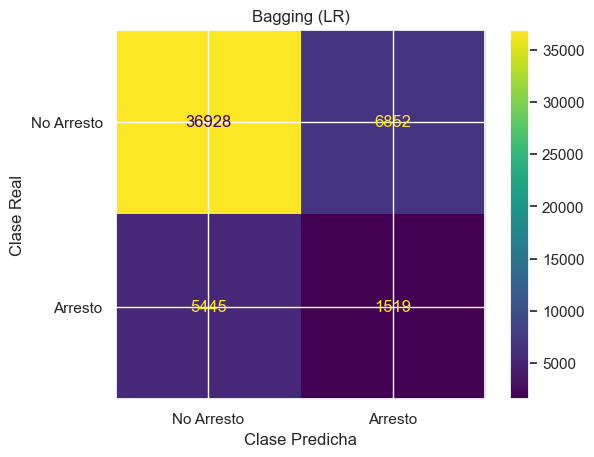

In [26]:
# Gráfica Matriz de Confusión
plot_confusion_matrix(y_test, pred_bagging, labels=["No Arresto", "Arresto"], model_name="Bagging (LR)")

### Clasificador AdaBoost 

In [22]:
start = time.time() # Estampa de tiempo para computar métricas

# Entrenamiento
model_adaboost = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=5), n_estimators=20, random_state=seed)
model_adaboost.fit(X_train, y_train)
end_train = time.time()

# Predicciones
pred_adaboost = model_adaboost.predict(X_test)
end_predict = time.time()

print("Classification Report: \n", classification_report(y_test, pred_adaboost))
muestra_metricas("AdaBoost", y_test, pred_adaboost, start, end_train, end_predict)

Classification Report: 
               precision    recall  f1-score   support

           0       0.88      0.88      0.88     43780
           1       0.22      0.21      0.22      6964

    accuracy                           0.79     50744
   macro avg       0.55      0.55      0.55     50744
weighted avg       0.79      0.79      0.79     50744

#######################################
Accuracy (Exactitud): 78.76%
Recall (Recuperación): 78.76%
Precision (Precisión): 78.54%
F1-Score: 78.65%
MCC (Matthews Correlation Coefficient): 9.36%
Tiempo de entrenamiento: 52.5134 s
Tiempo de predicción: 0.1315 s
Tiempo total: 52.6449 s
#######################################


Clasificador: AdaBoost
Sensibilidad: 0.2137
Especificidad: 0.8789
Exactitud balanceada: 0.5463


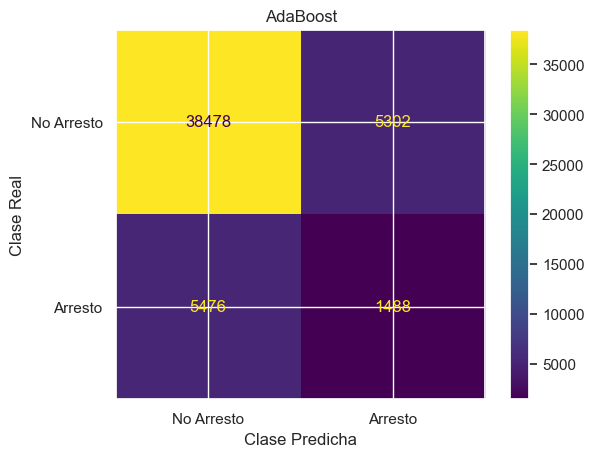

In [23]:
# Gráfica Matriz de Confusión
plot_confusion_matrix(y_test, pred_adaboost, labels=["No Arresto", "Arresto"], model_name="AdaBoost")

### XGBoost

In [19]:
start = time.time() # Estampa de tiempo para computar métricas

# Entrenamiento
model_xgb = XGBClassifier()
model_xgb.fit(X_train, y_train)
end_train = time.time()

# Predicciones
pred_xgb = model_xgb.predict(X_test)
end_predict = time.time()

print("Classification Report: \n", classification_report(y_test, pred_xgb))
muestra_metricas("XGBoost", y_test, pred_xgb, start, end_train, end_predict)

Classification Report: 
               precision    recall  f1-score   support

           0       0.88      0.92      0.90     43780
           1       0.30      0.20      0.24      6964

    accuracy                           0.82     50744
   macro avg       0.59      0.56      0.57     50744
weighted avg       0.80      0.82      0.81     50744

#######################################
Accuracy (Exactitud): 82.46%
Recall (Recuperación): 82.46%
Precision (Precisión): 79.95%
F1-Score: 81.03%
MCC (Matthews Correlation Coefficient): 14.97%
Tiempo de entrenamiento: 2.4176 s
Tiempo de predicción: 0.0921 s
Tiempo total: 2.5097 s
#######################################


Clasificador: XGBoost
Sensibilidad: 0.2038
Especificidad: 0.9233
Exactitud balanceada: 0.5635


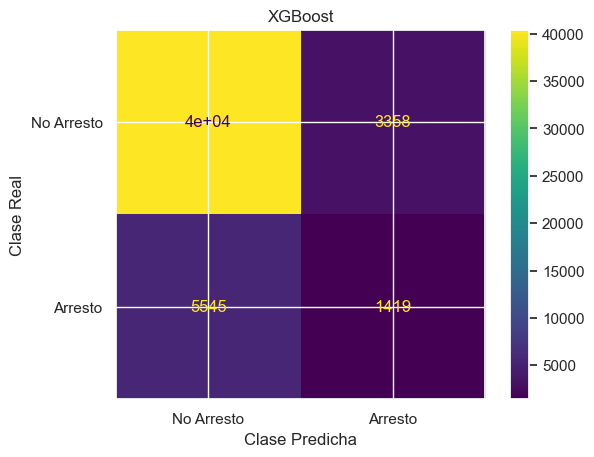

In [20]:
# Gráfica Matriz de Confusión
plot_confusion_matrix(y_test, pred_xgb, labels=["No Arresto", "Arresto"], model_name="XGBoost")

## Comparación de Modelos

In [27]:
model_performance.fillna(.90,inplace=True)
model_performance.style.background_gradient(cmap='coolwarm').format({'Accuracy': '{:.2%}',
                                                                     'Precision': '{:.2%}',
                                                                     'Recall': '{:.2%}',
                                                                     'F1-Score': '{:.2%}',
                                                                     'MCC score': '{:.2%}',
                                                                     'Entrenamiento (s)':'{:.3f}',
                                                                     'Predicción (s)':'{:.3f}',
                                                                     'Tiempo Total (s)':'{:.3f}',
                                                                     })

,Accuracy,Recall,Precision,F1-Score,MCC score,Entrenamiento (s),Predicción (s),Tiempo Total (s)
Regresión Logística,75.68%,75.68%,77.69%,76.64%,5.74%,0.182,0.004,0.186
K-Nearest Neighboors (k=10),72.00%,72.00%,78.52%,74.78%,8.84%,1.402,5.188,6.589
SVM Linear,75.73%,75.73%,77.69%,76.66%,5.74%,0.318,0.004,0.321
Árbol de Decisión,70.64%,70.64%,78.39%,73.87%,8.18%,11.603,0.021,11.624
Random Forest,79.77%,79.77%,79.42%,79.59%,13.10%,43.202,0.383,43.585
XGBoost,82.46%,82.46%,79.95%,81.03%,14.97%,2.418,0.092,2.510
AdaBoost,78.76%,78.76%,78.54%,78.65%,9.36%,52.513,0.132,52.645
Bagging (LR),75.77%,75.77%,77.68%,76.68%,5.71%,4.805,0.264,5.069
